# Climate dynamics
## Predicting the weather: timeseries approach
In this part of the climate dynamics tutorial, we will try to predict the temperature in Oxford on 19th November 2025. Here we will use daily timeseries data from a historical simulation of a climate model. 

Import all the requirements we need. We will be using `xarray` to open datasets again.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import nc_time_axis
from IPython.display import display, Latex
from scipy.constants import convert_temperature

As we are using timeseries data, we will select daily time resolution. Since the task requires us to use CMIP6 data, we will use the historical experiment - this means it is the CMIP6 historical simulation, so it is may not be exactly in line with observations. 

In [2]:
data_path = "/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/day/tas/gn/v20190627/"
filename = f"{data_path}tas_day_UKESM1-0-LL_historical_r1i1p1f2_gn_19500101-20141230.nc"

In [3]:
ds = xr.open_dataset(filename)
ds

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 23400, bnds: 2, lat: 144, lon: 192)
Coordinates:
  * time       (time) object 187kB 1950-01-01 12:00:00 ... 2014-12-30 12:00:00
  * lat        (lat) float64 1kB -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * lon        (lon) float64 2kB 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 374kB ...
    lat_bnds   (lat, bnds) float64 2kB ...
    lon_bnds   (lon, bnds) float64 3kB ...
    tas        (time, lat, lon) float32 3GB ...
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  144000.0
    creation_date:          2019-06-25T11:32:40Z
    ...                     ...
    title:                  UKESM1-0-LL output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/eca89b1b-3315-49ce-84d6-cb566ce0de6c

Select the variables and timeseries that is of interest for us. We want to get the near-surface air temperature variable `tas`.

In [4]:
surface_temp = ds["tas"] 
time = ds["time"] 
surface_temp

<xarray.DataArray 'tas' (time: 23400, lat: 144, lon: 192)> Size: 3GB
[646963200 values with dtype=float32]
Coordinates:
  * time     (time) object 187kB 1950-01-01 12:00:00 ... 2014-12-30 12:00:00
  * lat      (lat) float64 1kB -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 2kB 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    height   float64 8B ...
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    original_name:  mo: (stash: m01s03i236, lbproc: 128)
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-06-25T11:32:40Z altered by CMOR: Treated scalar dime...

## Time series of temperature in Oxford

The latitude and longitude of Oxford is: 51.7520° N, 1.2577° W. Select the grid cell nearest to this latitude and longitude and check its behaviour over time.

In [5]:
surface_temp_Oxford = surface_temp.sel(lat=51.7520, lon=1.2577, method='nearest')
surface_temp_Oxford

<xarray.DataArray 'tas' (time: 23400)> Size: 94kB
[23400 values with dtype=float32]
Coordinates:
  * time     (time) object 187kB 1950-01-01 12:00:00 ... 2014-12-30 12:00:00
    lat      float64 8B 51.88
    lon      float64 8B 0.9375
    height   float64 8B ...
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    original_name:  mo: (stash: m01s03i236, lbproc: 128)
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-06-25T11:32:40Z altered by CMOR: Treated scalar dime...

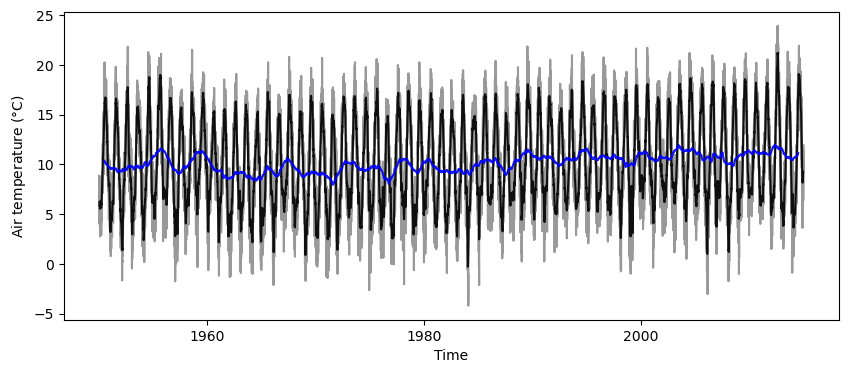

In [6]:
# Plot air temperature with time
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
plt.plot(time, convert_temperature(surface_temp_Oxford, "K", "C"), 
         color="gray", alpha=0.8)
plt.ylabel("Air temperature ($\degree$C)")
plt.xlabel("Time")

# Add rolling averages to this plot
# Monthly rolling averages
rolling_surface_temp_30 = surface_temp_Oxford.rolling(time=30, center=True).mean()
plt.plot(rolling_surface_temp_30.time, convert_temperature(rolling_surface_temp_30, "K", "C"), 
         color="black", alpha=0.9)

# Annual rolling averages
rolling_surface_temp_360 = surface_temp_Oxford.rolling(time=360, center=True).mean()
plt.plot(rolling_surface_temp_360.time, convert_temperature(rolling_surface_temp_360, "K", "C"), 
         color="blue", alpha=0.9)

## Climatology
In general, the "climatology" prediction is defined based on the temperature for a given location on a given date from the entire history. We generally assume we need at least 30 years of data. 


In [7]:
month = "11"
day = "19"
n_days_per_year = 360    # Met office model uses 360 day-years

In [8]:
# Climatology estimated from full dataset.
surface_temp_Oxford_climatology = surface_temp_Oxford.sel(time=slice(
    f"1850-{month}-{day}", 
    f"2014-{month}-{day}", 
    n_days_per_year))
surface_temp_Oxford_climatology_mean = surface_temp_Oxford_climatology.mean()
surface_temp_Oxford_climatology_std = surface_temp_Oxford_climatology.std()

Latex(f"Predicted temperature on 19th November 2025 is \
{surface_temp_Oxford_climatology_mean:.4f} $\pm$ {surface_temp_Oxford_climatology_std:.4f} K")

<IPython.core.display.Latex object>

How does predicted temperature change if we use a climatology estimate over last 30 years only?

In [9]:
# Last 30 years: 1984-2014
surface_temp_Oxford_30yrclimatology = surface_temp_Oxford_climatology.sel(
    time=slice(f"1984-{month}-{day}", f"2014-{month}-{day}"))
surface_temp_Oxford_30yrclimatology_mean = surface_temp_Oxford_30yrclimatology.mean()
surface_temp_Oxford_30yrclimatology_std = surface_temp_Oxford_30yrclimatology.std()

Latex(f"Predicted temperature on 19th November 2025 is \
{surface_temp_Oxford_30yrclimatology_mean:.4f} $\pm$ {surface_temp_Oxford_30yrclimatology_std:.4f} K")

<IPython.core.display.Latex object>

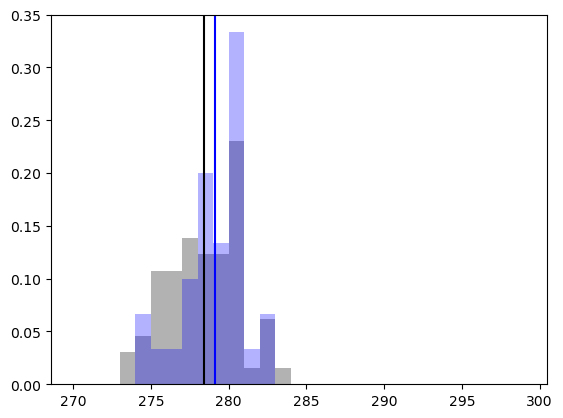

In [10]:
# Predict a distribution from current distribution of data
plt.hist(surface_temp_Oxford_climatology, bins = np.arange(270., 300., 1.), 
         color="black", alpha=0.3, density=True)
plt.axvline(surface_temp_Oxford_climatology_mean, color="black")
plt.hist(surface_temp_Oxford_30yrclimatology, bins = np.arange(270., 300., 1.), 
         color="blue", alpha=0.3, density=True)
plt.axvline(surface_temp_Oxford_30yrclimatology_mean, color="blue")

## Advanced: consider changing climate.
The prediction we made is a very common approach called "climatology". Numerical weather prediction typically use the climatology as a baseline that we should be able to beat with more advanced techniques. We assumed a stationary climate, how would you account for changing climate? Here we will try to account for this with a linear regression. 

Text(0.5, 0, 'Year')

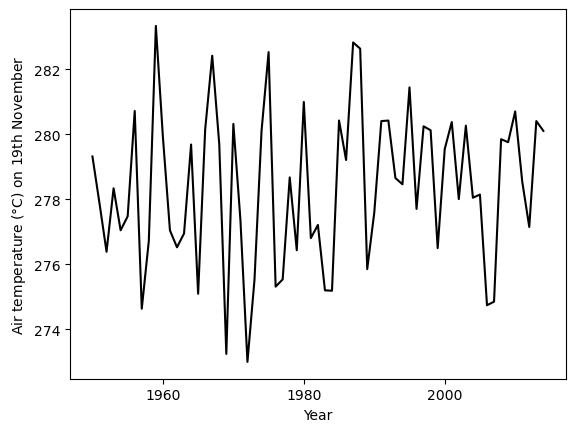

In [11]:
plt.plot(surface_temp_Oxford_climatology.time, surface_temp_Oxford_climatology, color="black")
plt.ylabel("Air temperature ($\degree$C) on 19th November")
plt.xlabel("Year")

Can we fit linear regression to this?

In [12]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
x = np.arange(1950, 2015).reshape(-1, 1)
y = surface_temp_Oxford_climatology.values.reshape(-1, 1)
reg.fit(x, y)

LinearRegression()

In [13]:
x_future = np.arange(2015, 2026).reshape(-1, 1)
predict_future = reg.predict(x_future)
predict_past = reg.predict(x)

Text(0.5, 0, 'Year')

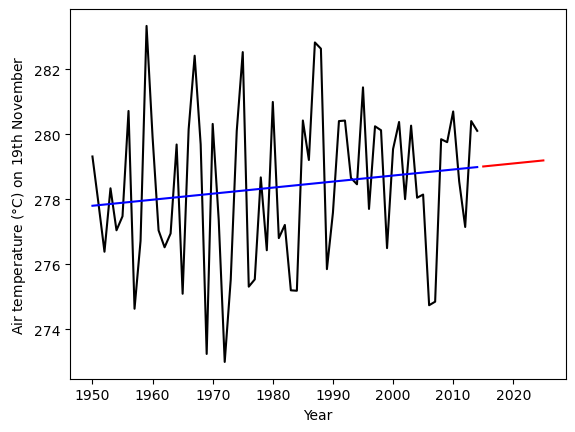

In [14]:
plt.plot(x, y, color="black")
plt.plot(x, predict_past, color="blue")
plt.plot(x_future, predict_future, color="red")
plt.ylabel("Air temperature ($\degree$C) on 19th November")
plt.xlabel("Year")

Can we add uncertainty estimates to this? For example, assuming the 1 standard deviation is constant with time:

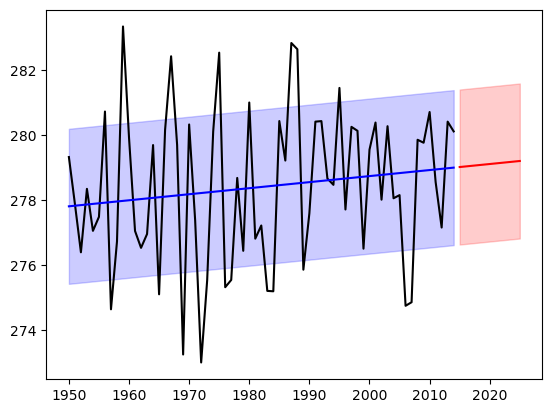

In [15]:
past_std = np.std(y)
plt.plot(x, y, color="black")
plt.plot(x, predict_past, color="blue")
plt.fill_between(x[:,0], 
                 predict_past[:,0] - past_std, 
                 predict_past[:,0] + past_std, 
                 color="blue",
                 alpha=0.2)

plt.plot(x_future, predict_future, color="red")
plt.fill_between(x_future[:,0], 
                 predict_future[:,0] - past_std, 
                 predict_future[:,0] + past_std, 
                 color="red",
                 alpha=0.2)


In [16]:
predict_2025 = reg.predict(np.array([2025]).reshape(-1, 1))[0, 0]
Latex(f"Predicted temperature on 19th November 2025 is {predict_2025:.4f} $\pm$ {past_std:.4f}")

<IPython.core.display.Latex object>

Think about ways to improve upon this using more data, more advanced methods, more models, etc.